In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive/MyDrive/Citadel_Data')

**Question idea:** 

1. Can we cluster effectiveness of headlines by the raw text?
2. If 1 is true, can we also categories the raw text into sentiment (pre-trained model) to produce analysis on which sentiments best attract interest? (i.e. In a social experiment context)
3. Can we compare the results of 1 to another benchmark? i.e. are there clusters for 'Winner'/'Not winner' that are dependent on time of release?
  **NB:** statistical comparision would require a held-out validation set, hopefully not too difficult but something to consider.

**Method:**

1. Represent headlines as a scipy sparse matrix representing sets feature vectors ((n_headlines x n_features) before making into sparse matrix)
2. Pass into text classification method (Naive Bayes or SVM - scikit-learn packages for both)
3. Train on entire data-set (if we take this approach we would not be looking at predictions, but instead at the net classification - like a semi-supervised algorithm (unspuervised in nature, excpet for the fact that the clusters are then labeled as 'Winner'/'Not Winner') - similar to image segmentation, just on text)
4. Feature vectors can be visualised by reducing dimensions of sparse vectors (TruncatedSVD?) and then passing through to a dimensionality mapping algorithm such as t-SNE for visualisation - more qualitative than quantitative due to t-SNEs almost arbitrary variation with parameters
5. If the SVM/Naive Bayes clustering fails to produce meaningful results, but t-SNE shows distinct clusters, clusters could be formed directly from the t-SNE (i.e. a non-linear mapping of feature vectors before clustering maybe helpful). **NB:** t-SNE is known to produce false-clusters, so a range of parameters should be tried and checked to produce same results if this approach is to be used

**(BK 02/11) Headings pre-processing:**

In [ ]:
from tqdm import tqdm
import pandas as pd

nrows = 50000
data = pd.read_csv('packages.csv', nrows=nrows)
headlines = data['headline']
test_ids = data['test_id']
image_ids = data['image_id']
impression_click_ratio = data['clicks'].divide(data['impressions'])
first_place = data['first_place']

# We only want to include the headline if it was changed whilst controls held constant. 
# If this is the case, then there will only be 1 instance of that headline in the headlines series, 
# and .get_loc() returns an integer location.
headline_dict = {'picked':[], 'not_picked':[]} 
index = {'picked':[], 'not_picked':[]} 
for i, picked in tqdm(enumerate(first_place), total=nrows):
  loc = pd.Index(headlines).get_loc(headlines[i]) 
  if type(loc) == int:
    if picked == True:
      index['picked'].append(loc)
      headline_dict['picked'].append(headlines[i])
    elif picked == False: 
      headline_dict['not_picked'].append(headlines[i])
      index['not_picked'].append(loc)

print()
print(f"Length of picked headlines array: {len(headline_dict['picked'])}")
print(f"Length of not picked headlines array: {len(headline_dict['not_picked'])}")

FileNotFoundError: ignored

In [ ]:
# Make sure that no headlines are in both, as this would cause false-classification.
assert [statement not in headline_dict['not_picked'] for statement in headline_dict['picked']]

**(BK 02/11) Trying to cluster 'Picked'/'Not picked' from headline content:** 

***!!NEED TO TURN FROM SUPERVISED CLASSIFICATION TO CLUSTERING!!*** 

***!!LEARNING TO JUST SAY NOT_PICKED!!***

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

# Build the pipeline for the sklearn classification:
# 1. Vectorise the raw text stream input into a scipy sparse matrix for training
# 2. Normalise the vectors to account for differences in feature length (headline length here) - i.e. greater vocab in longer texts
# 3. Build the classifier (e.g. SVM) ready for normalised scipy sparse inputs to be passed through
def build_pipeline(bigrams=False, trigrams=False, use_idf=True):
        
        if bigrams and not trigrams:
            ngram_range = (1,2)
        elif trigrams:
            ngram_range = (1,3)
        else:
            ngram_range = (1,1)
        
        text_clf = Pipeline([('vect', CountVectorizer(ngram_range=ngram_range)),
                                  ('tfidf', TfidfTransformer(use_idf=use_idf)),
                                  ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),])
        return text_clf

In [ ]:
frac = 0.8 # Fraction of data to train on (rest is held out for validation)
input_features = []
labels = []

for feature in headline_dict['not_picked'][:int(frac * len(headline_dict['not_picked']))]:
  input_features.append(feature)
  labels.append(0)
for feature in headline_dict['picked'][:int(frac * len(headline_dict['picked']))]:
  input_features.append(feature)
  labels.append(1)

In [ ]:
pipeline = build_pipeline()
pipeline.fit(input_features, labels)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [ ]:
test_features = []
labels = []
for feature in headline_dict['not_picked'][int(frac * len(headline_dict['not_picked'])):]:
  test_features.append(feature)
  labels.append(0)
for feature in headline_dict['picked'][int(frac * len(headline_dict['picked'])):]:
  test_features.append(feature)
  labels.append(1)

test_results = pipeline.predict(test_features)

true = []
for i, result in enumerate(test_results):
  if result == labels[i]: true.append(1)
  else: true.append(0)

print(f"Accuracy is {100*sum(true)/len(true):.1f}%")

Accuracy is 81.4%


**(BK 03/11) Using Doc2Vec for word embedding - training on the IMDB dataset**

For memory reasons, I have run all code for Doc2Vec locally on my laptop, and will import results for plotting if they are promising.

**(BK 04/11) Looking at basic click-rate patterns**

In [ ]:
rate = {'picked':[], 'not_picked':[]}
for ind in index['picked']:
  rate['picked'].append(data['clicks'][ind] / data['impressions'][ind])

for ind in index['not_picked']:
  rate['not_picked'].append(data['clicks'][ind] / data['impressions'][ind])

assert len(rate['picked']) == len(headline_dict['picked'])

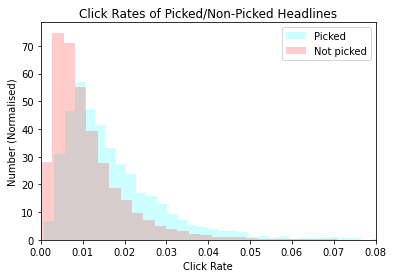

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

bins = 50
plt.hist(np.array(rate['picked']), bins=bins, label='Picked', density=True, color='cyan', alpha=0.2)
plt.hist(np.array(rate['not_picked']), bins=bins, label='Not picked', density=True, color='red', alpha=0.2)
plt.legend()
plt.xlabel('Click Rate')
plt.ylabel('Number (Normalised)')
plt.title('Click Rates of Picked/Non-Picked Headlines')
plt.xlim(0,0.08)
plt.show()

**MK 03/11 Exploratory Data Analysis**

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import statistics

In [ ]:
nrows=50000
packageData = pd.read_csv('/content/drive/MyDrive/Datathon Materials/packages.csv', nrows=nrows)

In [ ]:
## PACKAGE DATA SUMMARY STATISTICS

# basic information about data frame
print(packageData.info())
# summarising numerical variables
display(packageData.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   created_at   50000 non-null  object
 1   test_week    50000 non-null  object
 2   test_id      50000 non-null  object
 3   headline     50000 non-null  object
 4   image_id     49850 non-null  object
 5   excerpt      42640 non-null  object
 6   lede         49930 non-null  object
 7   slug         50000 non-null  object
 8   share_text   8014 non-null   object
 9   share_image  13883 non-null  object
 10  impressions  50000 non-null  int64 
 11  clicks       50000 non-null  int64 
 12  first_place  50000 non-null  bool  
 13  winner       50000 non-null  bool  
dtypes: bool(2), int64(2), object(10)
memory usage: 4.7+ MB
None


,impressions,clicks
count,50000.000000,50000.000000
mean,3314.960460,47.672820
std,1310.229734,41.950565
min,13.000000,0.000000
25%,2543.000000,21.000000
50%,3029.000000,37.000000
75%,3691.000000,61.000000
max,25314.000000,975.000000


In [ ]:
# checking percentage NaN values
print('Percentage of headlines missing: %',(packageData['headline'].isnull().sum()*100)/len(packageData['headline']))
print('Percentage of image IDs missing: %',(packageData['image_id'].isnull().sum()*100)/len(packageData['image_id']))

Percentage of headlines missing: % 0.0
Percentage of image IDs missing: % 0.3


In [ ]:
# Subsetting columns of data frame to include only variables which will be used in our analysis
packageData = packageData[['created_at', 'test_week', 'test_id', 'headline', 'image_id', 'impressions', 'clicks', 'first_place', 'winner']]
print(packageData.info())
# removing rows which contain NaN values
packageData = packageData.dropna(axis=0, how='any').reset_index(drop=True)
print(packageData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   created_at   50000 non-null  object
 1   test_week    50000 non-null  object
 2   test_id      50000 non-null  object
 3   headline     50000 non-null  object
 4   image_id     49850 non-null  object
 5   impressions  50000 non-null  int64 
 6   clicks       50000 non-null  int64 
 7   first_place  50000 non-null  bool  
 8   winner       50000 non-null  bool  
dtypes: bool(2), int64(2), object(5)
memory usage: 2.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49850 entries, 0 to 49849
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   created_at   49850 non-null  object
 1   test_week    49850 non-null  object
 2   test_id      49850 non-null  object
 3   headline     49850 non-null  object
 4   image_id     49850

Number of test conducted:  13909
Mean:  3.584010353008843
Median:  4.0
Standard Deviation 1.7252519771636685

Frequency Table: 
4     4304
1     2281
5     1925
2     1823
3     1702
6     1456
7      240
8      117
9       26
10      14
11      12
12       4
14       3
15       1
13       1
dtype: int64


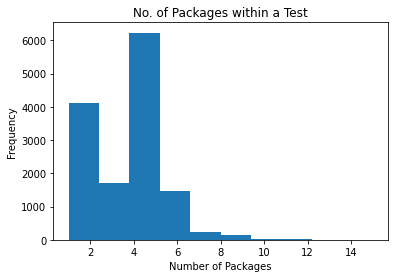

In [ ]:
## EXAMINING NUMBER OF TESTS AND NUMBER OF PACKAGES WITHIN A TEST

noTests = packageData['test_id'].nunique()
print('Number of test conducted: ', noTests)

testCounts = pd.Series(Counter(packageData['test_id']).values())

print('Mean: ', testCounts.mean())
print('Median: ', testCounts.median())
print('Standard Deviation', testCounts.std())
print('\nFrequency Table: ')
print(testCounts.value_counts())
plt.hist(testCounts)
plt.xlabel('Number of Packages')
plt.ylabel('Frequency')
plt.title('No. of Packages within a Test')
plt.show()

In [ ]:
## DETERMINING HOW OFTEN IMAGES ARE USED ON AVERAGE

timesUsed = round(len(packageData['image_id'])/packageData['image_id'].nunique(), 3)
print('images are used {} times on average'.format(timesUsed))

images are used 2.616 times on average


We need to determine how many distinct headlines within a test have the same image, as these are the only ones we can directly compare to investigate our chosen treatment effect. Is there more than two distinct headlines?  Also, is there pseudoreplication/duplication in the data. That is, are there packages which have the same headline and image as another package. An average of the pseudoreplicates will be need replace them. Also, if this happens a lot we might be able to examine the variance in click rate for the same package. This in turn could be used to test if packages which have the treatment effect are significantly different from other packages.

In [ ]:
## SUMARISING INDIVIDUAL TESTS

# creating dictionary to store information about individual tests
testDic = {}
# extraction list of unique test IDs
uniqueTestIDs = Counter(packageData['test_id']).keys()

# looping through tests, extracting relevant information about them, and adding this to testDic
for testID in tqdm(uniqueTestIDs):
    testDic[testID] = []
    packagesInTest =  packageData[packageData['test_id'] == testID]
    # storing indexes of packages so we can subset them from main dataframe
    testDic[testID].append(packagesInTest.index)
    # recording the number of times each image appears within a test
    testDic[testID].append(Counter(packagesInTest['image_id']).values())
    # Grouping Images by headline to identify duplicates
    duplicates = packagesInTest.groupby(['headline','image_id'], as_index = False).size()['size']
    #duplicates = packagesInTest.pivot_table(columns=['image_id','headline'], aggfunc='size').values
    testDic[testID].append(duplicates)

100%|██████████| 13909/13909 [01:47<00:00, 129.12it/s]


In [ ]:
# Determining total number of redundant packages
TotReplicates = 0
for test in tqdm(testDic):
  TotReplicates += testDic[test][2].subtract(1).sum()

print('Total number of redundant packages: ', TotReplicates)

# Examining structure of replicates
NumReplicates = []
for test in tqdm(testDic):
  if (testDic[test][2].subtract(1).sum() > 0):
    NumReplicates.append(str(testDic[test][2].subtract(1).values))

print('Most Common Duplicate Structures:\n', Counter(NumReplicates).most_common(10))

100%|██████████| 13909/13909 [00:03<00:00, 4235.44it/s]


Total number of redundant packages:  6734


100%|██████████| 13909/13909 [00:03<00:00, 3513.66it/s]

Most Common Duplicate Structures:
 [('[3]', 725), ('[4]', 350), ('[1]', 330), ('[2]', 297), ('[5]', 211), ('[1 1]', 55), ('[2 0]', 41), ('[6]', 35), ('[0 2]', 32), ('[1 0]', 29)]


- There are 6846 test structures which contain replication

### Analysis Variance and Distribution of Click-Rate

Since we have got repeated observations, we can investigate the population variance in package-click rate

In [ ]:
## Extracting package ID for replicated values

RepID = {}

uniqueTestIDs = Counter(packageData['test_id']).keys()
for testID in tqdm(uniqueTestIDs):
    packagesInTest =  packageData[packageData['test_id'] == testID]
    withoutDuplicatesIndex = packagesInTest.drop_duplicates(subset=['headline', 'image_id'], keep=False).index.values
    duplicatesIndex = packagesInTest.index.drop(withoutDuplicatesIndex)
    RepID[testID] = duplicatesIndex.values

100%|██████████| 13909/13909 [01:22<00:00, 169.48it/s]


__Assumption: The distribution of click-rate for any given package is identical__

Under this assumption, we can use a pooled variance to estimate the population variance $\sigma^2$
See: https://en.wikipedia.org/wiki/Pooled_variance for formula details

In [ ]:
## CALCULATING VARIANCE OF CLICKRATE

packageData['clickrate'] = packageData["clicks"]/packageData["impressions"]

Numerator = 0
Denominator = 0
k = 0
uniqueTestIDs = Counter(packageData['test_id']).keys()
for testID in tqdm(uniqueTestIDs):
    if (len(RepID[testID]) > 0):
        duplicates = packageData.iloc[RepID[testID], ]
        groupedDuplicates = duplicates.groupby(['headline'])
        for headline in Counter(duplicates['headline']).keys():
            rate = groupedDuplicates.get_group(headline)['clickrate']
            if (len(rate) > 1):
                k += 1
                Denominator += len(rate)
                Numerator += (len(rate) - 1) * statistics.variance(rate)

pooledSampleVar = Numerator/(Denominator - k)
print('Estimated Pooled Variance: ', pooledSampleVar)

100%|██████████| 13909/13909 [00:04<00:00, 3375.49it/s]

Estimated Pooled Variance:  1.2263551091851131e-05


100%|██████████| 13909/13909 [00:01<00:00, 11703.90it/s]


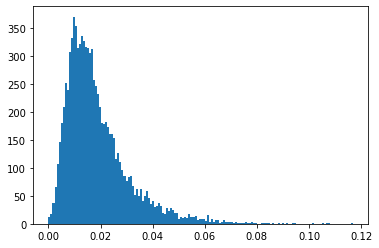

In [ ]:
## DISTRIBUTION OF CLICK RATE

rates = []
uniqueTestIDs = Counter(packageData['test_id']).keys()
for testID in tqdm(uniqueTestIDs):
    if (len(RepID[testID]) > 0):
        rates.extend(packageData.iloc[RepID[testID], ]['clickrate'].values)
plt.hist(rates, bins=150)
plt.show()

**AS 03/11 Exploratory Data Analysis**

## Exploratory Data Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf



In [ ]:
packages.head()

,created_at,test_week,test_id,headline,image_id,excerpt,lede,slug,share_text,share_image,impressions,clicks,first_place,winner,clickrate
0,2014-11-20,2014-11-17,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,546d6fa19ad54eec8d00002d,Things that matter. Pass 'em on.,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,Anyone who's ever felt guilty about shopping a...,NaN,3052,150,True,True,0.049148
1,2014-11-20,2014-11-17,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,546d6fa19ad54eec8d00002d,Things that matter. Pass 'em on.,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,Walmart is getting schooled by another retaile...,NaN,3033,122,False,False,0.040224
2,2014-11-20,2014-11-17,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,546d6fa19ad54eec8d00002d,Things that matter. Pass 'em on.,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,Walmart may not be crapping their pants over t...,NaN,3092,110,False,False,0.035576
3,2014-11-20,2014-11-17,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,546bc55335992b86c8000043,Things that matter. Pass 'em on.,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this-is-what-sexism-against-men-sounds-like-am...,"If you ever wondered, ""but what about the men?...",NaN,3526,90,False,False,0.025525
4,2014-11-20,2014-11-17,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,546d900426714cd2dd00002e,Things that matter. Pass 'em on.,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this-is-what-sexism-against-men-sounds-like-am...,"If you ever wondered, ""but what about the men?...",NaN,3506,120,True,False,0.034227


Let's create a new float column clickrate 

In [ ]:
packages["clickrate"] = packages["clicks"]/packages["impressions"]

In [ ]:
packages.describe()

,impressions,clicks,clickrate
count,150817.000000,150817.000000,150817.000000
mean,3569.046447,54.255648,0.015789
std,1435.995922,45.521282,0.012371
min,1.000000,0.000000,0.000000
25%,2745.000000,25.000000,0.007458
50%,3117.000000,42.000000,0.012509
75%,4089.000000,70.000000,0.020386
max,36908.000000,975.000000,0.183401


In [ ]:
packages.isna().sum()

created_at          0
test_week           0
test_id             0
headline            1
image_id          181
excerpt         16027
lede              104
slug                0
share_text     129917
share_image    101017
impressions         0
clicks              0
first_place         0
winner              0
clickrate           0
dtype: int64

There are only 5716 first place winners out of 7664 winners and 32122 first places. Roughly 75% of all winners are also listed on first place. What could be the reason that so many first place packages were not selected as winners i.e. that there are far fewer winners than first places.

In [ ]:
packages.loc[:,("first_place","winner")].sum()

first_place    32122
winner          7664
dtype: int64

In [ ]:
packages[packages.first_place.eq(True) & packages.winner.eq(True)].describe()

,impressions,clicks,clickrate,index
count,5716.000000,5716.000000,5716.000000,5716.000000
mean,3607.888034,84.818754,0.024348,77182.578202
std,1520.212110,62.591825,0.015587,43236.321859
min,194.000000,2.000000,0.000437,0.000000
25%,2723.000000,45.000000,0.013853,50008.750000
50%,3097.000000,69.000000,0.020544,74652.000000
75%,4100.250000,107.000000,0.030577,119527.000000
max,18038.000000,933.000000,0.136712,150784.000000


In [ ]:
#packages["index"]= packages.index

In [ ]:
# index = pd.MultiIndex.from_arrays(arrays, names=["test_id", "index"])
# packages.set_index(["test_id","index"]).sort_index()

How many of the first places had the highest clickrate?

In [ ]:
highest_clickrate = packages.groupby(["test_id"], sort=False)["clickrate"].transform(max) == packages["clickrate"] 
packages["highest_clickrate"] = highest_clickrate

We see that highest_clickrate and first place are not exactly the same, 32510 test_ids have a highest_clickrate, but only 32122 have a first_place

In [ ]:
sum(highest_clickrate)

32510

Can we find out what those packages have in common that achieved the highest clickrate, but are not labeled as first_place?

In [ ]:
packages[packages.highest_clickrate.eq(True) & packages.first_place.eq(False)]

In [ ]:
packages[packages.test_id.eq("546f486992f391bd48000025")]

,created_at,test_week,test_id,headline,image_id,excerpt,lede,slug,share_text,share_image,impressions,clicks,first_place,winner,clickrate,index,highest_clickrate
71,2014-11-21,2014-11-17,546f486992f391bd48000025,She Let Strangers Ask Her Questions About Lesb...,546d1b4bfd3617f091000041,Things that matter. Pass 'em on.,<p>I'll be honest. I've wondered about 7.</p>,she-let-strangers-ask-her-questions-about-lesb...,NaN,NaN,3029,84,False,False,0.027732,71,False
72,2014-11-21,2014-11-17,546f486992f391bd48000025,People Ask This Lesbian Questions And Her Rais...,546d1b4bfd3617f091000041,Things that matter. Pass 'em on.,<p>I'll be honest. I've wondered about 7.</p>,people-ask-this-lesbian-questions-and-her-rais...,I'll be honest. I've wondered about 7.,NaN,2985,103,True,False,0.034506,72,False
73,2014-11-21,2014-11-17,546f486992f391bd48000025,People Ask This Lesbian Questions And Her Rais...,546d1b4bfd3617f091000041,Things that matter. Pass 'em on.,<p>I'll be honest. I've wondered about 7.</p>,people-ask-this-lesbian-questions-and-her-rais...,"If you don't chuckle at LEAST twice, I don't k...",NaN,3093,81,False,False,0.026188,73,False
74,2014-11-21,2014-11-17,546f486992f391bd48000025,People Ask This Lesbian Questions And Her Rais...,546d1b4bfd3617f091000041,Things that matter. Pass 'em on.,<p>I'll be honest. I've wondered about 7.</p>,people-ask-this-lesbian-questions-and-her-rais...,I love how it's simultaneously hilarious and r...,NaN,3076,109,False,True,0.035436,74,True


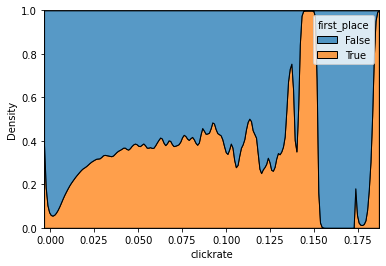

In [ ]:
sns.kdeplot(x=packages.clickrate, hue=packages.first_place, multiple="fill")

From here on the test dataset is filtered and prepared

In [ ]:
packages["test_week"] = pd.to_datetime(packages["test_week"])
packages["created_at"] = pd.to_datetime(packages["created_at"])

In [ ]:
clicks_over_time = packages.groupby(["test_week"], sort=True)["clicks"].sum()

It seems counterintuitive that the number of clicks per week dropped towards the end of the measure period

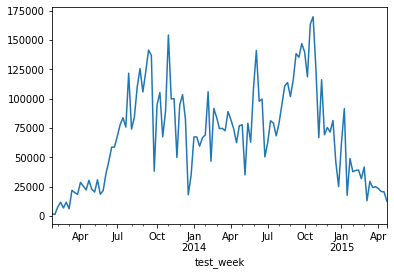

In [ ]:
clicks_over_time.plot()

In [ ]:
daily_users["date"] = pd.to_datetime(daily_users["date"])
daily_users = daily_users.set_index("date")
daily_pageviews["date"] = pd.to_datetime(daily_pageviews["date"])
daily_pageviews = daily_pageviews.set_index("date")

In [ ]:
daily_users.dtypes

users                 object
new_users             object
sessions_per_user    float64
sessions              object
session_duration      object
bounce_rate           object
pageviews             object
pages_per_session    float64
dtype: object

In [ ]:
daily_users['users'].isnull().sum()

0

In [ ]:
testpak = packages.groupby(['test_id','image_id']).aggregate({'impressions':'sum','clicks':'sum','first_place':'max','winner':'max', 'test_week':'nunique', 'headline':'nunique', 'slug':'count'})
testpak['clickrate'] = testpak['clicks']/testpak['impressions']
testpak

impressions  ...  clickrate
test_id                  image_id                               ...           
5143605e220cb80002000076 5332b5101fae79f09f00020c        20596  ...   0.013935
51436060220cb800020001df 5332ba641fae79f09f003410         8048  ...   0.008449
                         5332ba641fae79f09f003414         2733  ...   0.006952
51436060220cb800020001e1 5332ba161fae79f09f002c78        10641  ...   0.016070
51436060220cb800020001e3 5332ba141fae79f09f002c4e        10603  ...   0.017919
...                                                        ...  ...        ...
55417382313766001c440000 55417276343635001c550000         2049  ...   0.022450
                         55417276343635002c5e0000         1995  ...   0.011529
                         55417276343635002c5f0000         2067  ...   0.011611
55417f91343635002c7e0000 55417276343635001c550000        12132  ...   0.018958
55418d7b313132002c070000 55417276343635001c550000         6047  ...   0.010584

[71356 rows x 8 columns]

Cause and effect: we must keep all variables fixed and try to understand what was changed and how that provoked a reaction. Why would upworthy do A/B test that only differ by share_text, even though share_text is not shown to the users? How come there are test_ids without a first_place?

We could go for all test_ids that have no difference in image_id and test_week and perform some causal inference if they have a difference in headline. This way we can infere causality, not just correlation. There remain 15605 rows that satisfy these conditions. Note: there are test_ids that don't have a first_place, I suggest we could take the highest clickrate instead. It is to some extend dubious how first_place is exactly defined. There are headlines without images, which is ok for us

Another idea: We could also try to find out if varying the headline has a bigger effect than varying the image. 

In [ ]:
testset_id = testpak[testpak.test_week.eq(1) & testpak.headline.gt(1) & testpak.clicks.gt(0) & testpak.headline.eq(testpak.slug)].index.get_level_values(0)
testset_image = testpak[testpak.test_week.eq(1) & testpak.headline.gt(1) & testpak.clicks.gt(0) & testpak.headline.eq(testpak.slug)].index.get_level_values(1)

In [ ]:
testpak[testpak.test_week.eq(1) & testpak.headline.gt(1) & testpak.clicks.gt(0) & testpak.headline.eq(testpak.slug)]

,,impressions,clicks,first_place,winner,test_week,headline,slug,clickrate
test_id,image_id,,,,,,,,
5143605e220cb80002000076,5332b5101fae79f09f00020c,20596,287,True,True,1,5,5,0.013935
51436060220cb800020001df,5332ba641fae79f09f003410,8048,68,False,False,1,3,3,0.008449
51436060220cb800020001e1,5332ba161fae79f09f002c78,10641,171,False,False,1,4,4,0.016070
51436060220cb800020001e3,5332ba141fae79f09f002c4e,10603,190,True,True,1,4,4,0.017919
51436061220cb800020001e4,5332ba641fae79f09f003415,15576,96,True,True,1,4,4,0.006163
...,...,...,...,...,...,...,...,...,...
55413048643265002c840200,554139db333531001c060000,10146,19,True,False,1,5,5,0.001873
5541323d643265002cbc0200,554103dc643933001c260100,10176,49,True,False,1,5,5,0.004815
5541358d643933000c3c0300,5511a35f336563000c400000,10168,43,True,False,1,5,5,0.004229


**Note**: we have to be really careful with the samples, there are multiple doublicates that don't differ at all except for the clicks and impressions e.g. test_id 5143606b220cb800020005db

Those test_ids are excluded from our test sample we use to do inference and prediction on

In [ ]:
packages[packages.test_id.eq("5143606b220cb800020005db")]

,created_at,test_week,test_id,headline,image_id,excerpt,lede,slug,share_text,share_image,impressions,clicks,first_place,winner,clickrate,high_ctr_test,high_ctr_test_image
26061,2013-03-12,2013-03-11,5143606b220cb800020005db,Genius Inventor Cracks Secret Of Trees To Harn...,5332ba5c1fae79f09f003372,"Oh, And He’s 13.","<p>Watch out, Big Oil companies. This 13-year-...",genius-inventor-cracks-secret-of-trees-to-harn...,NaN,tree_thumb.jpg,2863,65,False,False,0.022703,False,False
50587,2013-03-12,2013-03-11,5143606b220cb800020005db,Genius Inventor Cracks Secret Of Trees To Harn...,5332ba5c1fae79f09f003372,Could this teenager cause the downfall of big ...,"<p>Watch out, Big Oil companies. This 13-year-...",genius-inventor-cracks-secret-of-trees-to-harn...,NaN,tree_thumb.jpg,2661,59,False,False,0.022172,False,False
50589,2013-03-12,2013-03-11,5143606b220cb800020005db,Genius Inventor Cracks Secret Of Trees To Harn...,5332ba5c1fae79f09f003372,Could this teenager cause the downfall of big ...,"<p>Watch out, Big Oil companies. This 13-year-...",genius-inventor-cracks-secret-of-trees-to-harn...,NaN,tree_thumb.jpg,2823,74,False,True,0.026213,False,False
50590,2013-03-12,2013-03-11,5143606b220cb800020005db,Meet The 13 Year-Old Who's Making Most Scienti...,5332ba5c1fae79f09f003372,Genius inventor cracks secret of trees to harn...,"<p>Watch out, Big Oil companies. This 13-year-...",meet-the-13-year-old-whos-making-most-scientis...,NaN,tree_thumb.jpg,2820,82,True,False,0.029078,True,True


In [ ]:
test_dataset = packages.loc[packages.test_id.isin(testset_id)]
test_dataset = test_dataset.loc[test_dataset.image_id.isin(testset_image)]


These are all packages that have at least 2 headlines per image_id within their test_ids, a unique test_week within their test_ids and as many headlines per test_id and image_id combination as packages (so no duplicate headlines). In addition, I deleted the test_ids that didn't havy any clicks at all among all packages. In total there are 16519 unique test_ids and 72135 packages 

In [ ]:
test_dataset.to_csv("/content/drive/MyDrive/DataOpen/test_packages.csv")

Keeping everything relevant for the test stable, we control what contributes towards higher clickrates. This way we can describe causality and not just correlation. This could look something like this, but with the sentiment. Then we can perform 

In [ ]:
highest_ctr = packages.loc[packages.test_id.isin(testset_id) & packages.image_id.isin(testset_image) & packages.high_ctr_test.eq(True)]
lower_ctr = packages.loc[packages.test_id.isin(testset_id) & packages.image_id.isin(testset_image) & packages.high_ctr_test.eq(False)]

In [ ]:
highest_ctr['winner'].mean()

0.1286483064260842

In [ ]:
lower_ctr['winner'].mean()

0.010649627263045794

This is what we could do in a very first step to get some basic hypothesis tested

In [ ]:
stats.ttest_ind(highest_ctr.winner, lower_ctr.winner, equal_var=False)

Ttest_indResult(statistic=43.7196654125302, pvalue=0.0)

## TIME SERIES SECTION

Research Questions:
 1. How has click rate changed over time? Can we model this behavior?
 2. How has sentiment changed over time? Can we model this behavior?
 3. correlation between sentiment and clickrate over time. Constant or time contingent?
 4. Possible Extra: How has good/neutral/bad sentiment effected the click rate over time?\*
 
\* This would require a comparison of time series. If we group the packages by binned sentiment score (e.g. 0-0.25: 'negative sentiment', 0.25-0.75: 'neutral sentiment', 0.75-1, 'positive sentiment') perhaps we could make a relative comparison of each series by taking the differences between them. For example, if good sentiment and neutral sentiment both trend down over time, but good sentiment - neutral sentiment trends up then we may conclude that good sentiment increases clickrate __relative to neutral sentiment__ . I'm not sure if theres a way to get absolute effects, but it might be interesting to make these comparisons anyway as long as we don't make false inferences.

#### ARIMA MODELLING OF CLICK RATE FOR ALL PACKAGES - NO SENTIMENT CONSIDERATION

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import statistics
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
from scipy import stats
from arch import arch_model

In [ ]:
test_packages = pd.read_csv('/content/drive/MyDrive/Datathon Materials/packages.csv')

In [ ]:
# prepping data 
test_packages['clickrate'] = test_packages["clicks"]/test_packages["impressions"]
test_packages = test_packages[['test_week', 'test_id', 'headline', 'image_id', 'clickrate']].copy()
test_packages["test_week"] = pd.to_datetime(test_packages["test_week"])
test_packages.head()

,test_week,test_id,headline,image_id,clickrate
0,2014-11-17,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,546d6fa19ad54eec8d00002d,0.049148
1,2014-11-17,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,546d6fa19ad54eec8d00002d,0.040224
2,2014-11-17,546d88fb84ad38b2ce000024,They're Being Called 'Walmart's Worst Nightmar...,546d6fa19ad54eec8d00002d,0.035576
3,2014-11-17,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,546bc55335992b86c8000043,0.025525
4,2014-11-17,546d902c26714c6c44000039,This Is What Sexism Against Men Sounds Like,546d900426714cd2dd00002e,0.034227


In [ ]:
clickRateTS = test_packages[['test_week', 'clickrate']].set_index('test_week').sort_index()
# Creating time series of average weekly click rate
weekly = clickRateTS.groupby('test_week').mean()
print('Shape of Data: ', weekly.shape)
display(weekly.head())

Shape of Data:  (119, 1)


,clickrate
test_week,
2013-01-21,0.024726
2013-01-28,0.024286
2013-02-04,0.023531
2013-02-11,0.020110
2013-02-18,0.014383


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


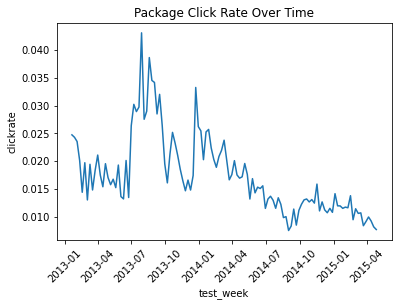

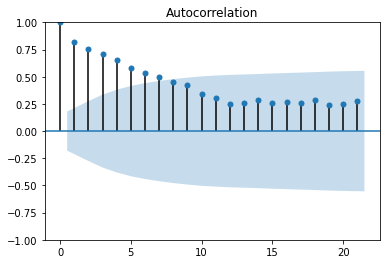

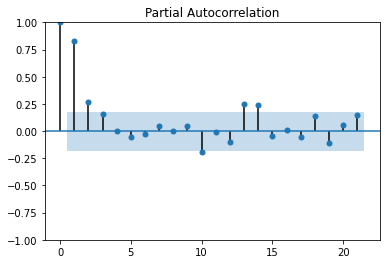

In [ ]:
# Visualising Time series, and plotting ACF & PACF
fig = plt.figure()
sns.lineplot(x=weekly.index, y=weekly['clickrate'])
plt.title('Package Click Rate Over Time')
plt.xticks(rotation=45)

tsaplots.plot_acf(weekly, alpha=0.05)
tsaplots.plot_pacf(weekly, alpha=0.05)
plt.show()



We see a linear decay in the sample ACF plot, indicating that there may be a non-stationary component to the series. We will perform an Augmented Dickey-Fuller test to check if this is the case.

In [ ]:
result = adfuller(weekly)
print('Test Statistic: ', result[0])
print('p-value: ', result[1])
print('Critical Values at 5%: ', result[4]['5%'])

Test Statistic:  -1.7888441550753797
p-value:  0.38601415743452616
Critical Values at 5%:  -2.8867966864160075


We fail to reject the null hypothesis, that the time series has a unit root. That is, the series is not stationary. We difference the series to remove this.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


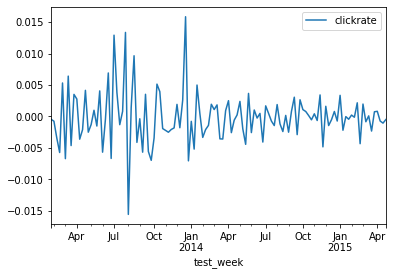

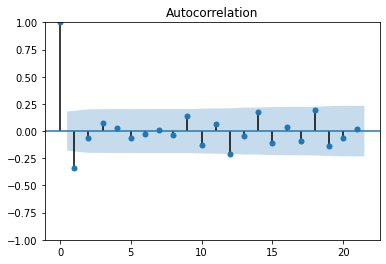

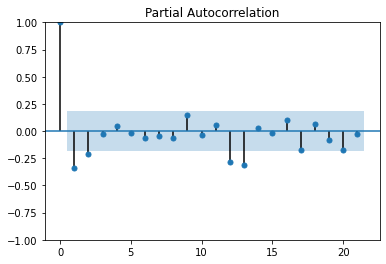

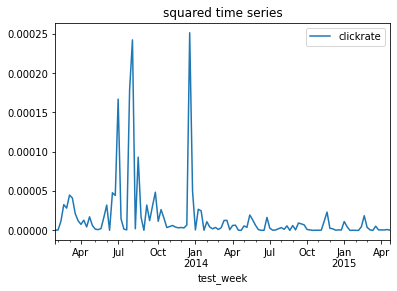

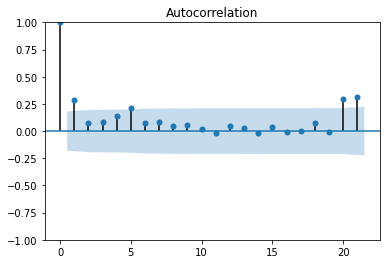

In [ ]:
# drop first observation in defferenced series as this goes to null
weeklyDiff = weekly.diff(periods=1)[1:]
# Visualising the differenced series
weeklyDiff.plot()
tsaplots.plot_acf(weeklyDiff, alpha=0.05)
tsaplots.plot_pacf(weeklyDiff, alpha=0.05)
# plotting Squared series & squared ACF to identify hetroskedastic variance
weeklyDiff.pow(2).plot(title='squared time series')
tsaplots.plot_acf(weeklyDiff.pow(2))
plt.show()

In [ ]:
result = adfuller(weeklyDiff)
print('Test Statistic: ', result[0])
print('p-value: ', result[1])
print('Critical Value at 5%: ', result[4]['5%'])

Test Statistic:  -10.739971697828857
p-value:  2.8345811118626223e-19
Critical Value at 5%:  -2.8867966864160075


Differencing the series once has removed the trend component (the original times series is integrated of order 1). Examining the ACF and PACF plots here seems to indicate that the the differenced series may be MA(1) since the ACF has only one non-null lag, while the PACF tails off exponentially. There is also a possible hetroskadastic component to the model, with variance in package click-rate falling over time.

Note: ARIMA(0,1,1) is not the only possible model here, the behavior of the ACF and PACF plots are also indicatve of a white noise with trend $Y_t = \alpha + \beta t + \epsilon_t$ However, this is not a useful model if we have heteroskedasticity.

In [ ]:
# Fitting Model
model = ARIMA(weekly, order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              clickrate   No. Observations:                  119
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 491.342
Date:                Sun, 07 Nov 2021   AIC                           -978.684
Time:                        09:30:24   BIC                           -973.143
Sample:                    01-21-2013   HQIC                          -976.434
                         - 04-27-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4146      0.061     -6.839      0.000      -0.533      -0.296
sigma2      1.411e-05   1.03e-06     13.665      0.000    1.21e-05    1.61e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


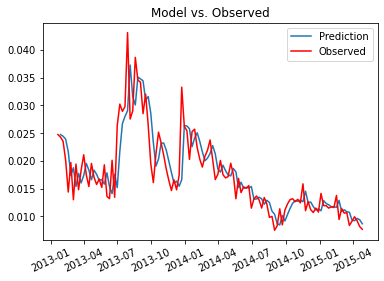

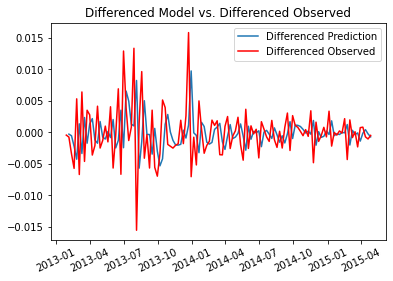

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


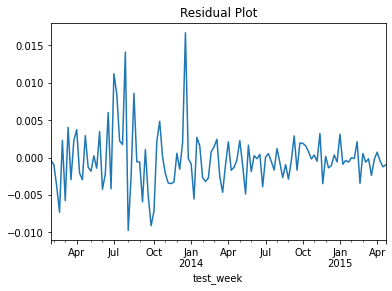

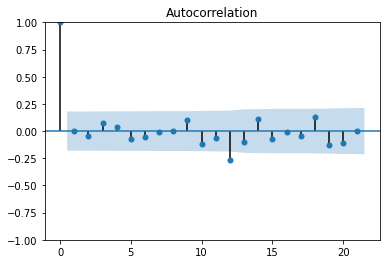

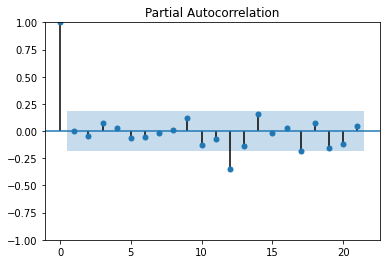

In [ ]:
# model predictions
preds = model_fit.predict(start=1, end=118)
# residual of modedl predictions
residuals = weekly['clickrate'][1:].subtract(preds.values)
# Plotting Fitted model vs Observed Time Series
plt.figure()
plt.plot(preds, label='Prediction')
plt.plot(weekly, color='r', label='Observed')
plt.title('Model vs. Observed')
plt.xticks(rotation=25)
plt.legend()

plt.show()
# Plotting Differenced Fitted Model vs Observed Differenced Time Series
predsDiff = preds.diff(periods=1)[1:]
weeklyDiff = weekly.diff(periods=1)[1:]
plt.figure()
plt.plot(predsDiff, label='Differenced Prediction')
plt.plot(weeklyDiff, color='r', label='Differenced Observed')
plt.title('Differenced Model vs. Differenced Observed')
plt.xticks(rotation=25)
plt.legend()
plt.show()
# Plotting Model Residuals
residuals.plot(title='Residual Plot')
tsaplots.plot_acf(residuals, alpha=0.05)
tsaplots.plot_pacf(residuals, alpha=0.05)
plt.show()

Ljung Box Test Results:
        lb_stat  lb_pvalue
21  26.092911   0.202928
Shapiro-Wilk Test Statistics: 0.8980158567428589, and p-value: 1.885210281216132e-07
McLeod-Li Test Results:
        lb_stat  lb_pvalue
21  42.534739   0.003602


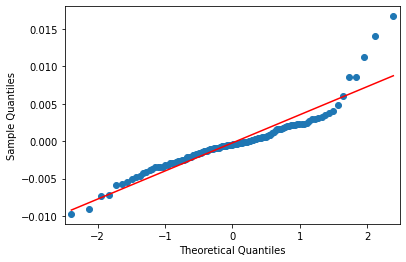

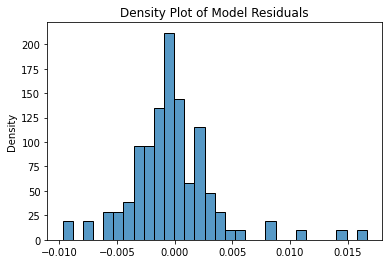

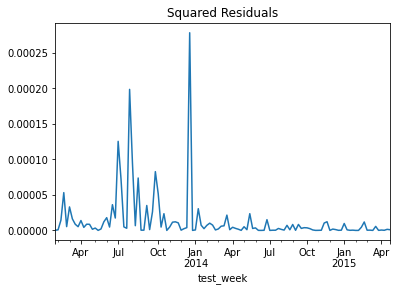

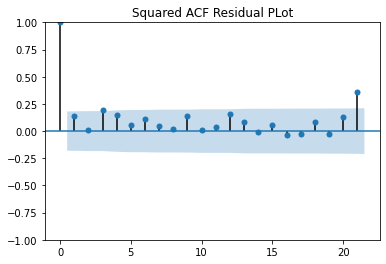

In [ ]:
# EXAMINING RESIDUALS

# Ljung Box test
print('Ljung Box Test Results:\n ', acorr_ljungbox(residuals, lags=[21]))
# Shapiro Wilk test for normality
print('Shapiro-Wilk Test Statistics: {}, and p-value: {}'.format(shapiro(residuals)[0], shapiro(residuals)[1]))
# McLeod-Li test
print('McLeod-Li Test Results:\n ', acorr_ljungbox(residuals.pow(2), lags=[21]))

# qqplot of residuals
sm.qqplot(residuals, line='s')
plt.show()
# histogram of residuals
plt.figure()
ax = sns.histplot(residuals, stat='density', bins=30).set_title('Density Plot of Model Residuals') 
plt.show()
# plotting squared residuals
residuals.pow(2).plot(title='Squared Residuals')
plt.show()
# AFC plots for squared residuals
tsaplots.plot_acf(residuals.pow(2), alpha=0.05, title='Squared ACF Residual PLot')
plt.show()


We have significant heteroskedasticity. It could be hypothesise that this may be cause by phenomena such as 'viral/trending' posts, where the usual model fails to apply

In [ ]:
# Creating GARCH(1,q) model, where q is set to one, its coefficients significance tested, incremented, and so on

# GARCH(1,0)
model = arch_model(residuals, mean='Zero', vol='GARCH', p=1, q=0)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      4,   Neg. LLF: -488.6714969222335
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -488.6714965697319
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.407e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.008
Vol Model:                       ARCH   Log-Likelihood:                488.671
Distribution:                  Normal   AIC:                          -973.343
Method:            Maximum Likelihood   BIC:                          -967.802
                                        No. Observations:                  118
Date:                Sun, Nov 07 2021   Df Residuals:                      118
Time:                        10:00:58   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      7.0649e-06  1.036e-08    682.210      0.000 [7.045e-06,7.085e-06]
alpha[1]       0.2000      0.183      1.093      0.274     [ -0.159,  0.559]
============================================================================

Covariance estimator: robust
"""

In [ ]:
# GARCH(1,1)
model = arch_model(residuals, mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -509.44343510937847
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -509.4434360745158
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.407e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.008
Vol Model:                      GARCH   Log-Likelihood:                509.443
Distribution:                  Normal   AIC:                          -1012.89
Method:            Maximum Likelihood   BIC:                          -1004.57
                                        No. Observations:                  118
Date:                Sun, Nov 07 2021   Df Residuals:                      118
Time:                        10:01:51   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.8260e-07  2.706e-10   1044.313      0.000 [2.821e-07,2.831e-07]
alpha[1]       0.1000  4.652e-02      2.150  3.157e-02   [8.832e-03,  0.191]
beta[1]        0.8800  2.535e-02     34.715 4.660e-264     [  0.830,  0.930]
============================================================================

Covariance estimator: robust
"""

In [ ]:
# GARCH(1,2)
model = arch_model(residuals, mean='Zero', vol='GARCH', p=1, q=2)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -510.20340042985606
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -510.2034000524083
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.407e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.008
Vol Model:                      GARCH   Log-Likelihood:                510.203
Distribution:                  Normal   AIC:                          -1012.41
Method:            Maximum Likelihood   BIC:                          -1001.32
                                        No. Observations:                  118
Date:                Sun, Nov 07 2021   Df Residuals:                      118
Time:                        10:03:19   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.8260e-07  2.680e-10   1054.338      0.000 [2.821e-07,2.831e-07]
alpha[1]       0.2000  7.728e-02      2.588  9.657e-03   [4.853e-02,  0.351]
beta[1]        0.3900      0.149      2.625  8.673e-03   [9.877e-02,  0.681]
beta[2]        0.3900      0.172      2.270  2.319e-02   [5.332e-02,  0.727]
============================================================================

Covariance estimator: robust
"""

In [ ]:
# GARCH(1,3)
model = arch_model(residuals, mean='Zero', vol='GARCH', p=1, q=3)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: -511.3068249158105
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -511.3068252451792
            Iterations: 5
            Function evaluations: 7
            Gradient evaluations: 1


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.407e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.008
Vol Model:                      GARCH   Log-Likelihood:                511.307
Distribution:                  Normal   AIC:                          -1012.61
Method:            Maximum Likelihood   BIC:                          -998.760
                                        No. Observations:                  118
Date:                Sun, Nov 07 2021   Df Residuals:                      118
Time:                        10:05:04   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.8260e-07  2.487e-10   1136.317      0.000 [2.821e-07,2.831e-07]
alpha[1]       0.2000      0.100      1.999  4.560e-02   [3.913e-03,  0.396]
beta[1]        0.2600      0.262      0.993      0.321     [ -0.253,  0.773]
beta[2]        0.2600      0.143      1.820  6.875e-02  [-1.999e-02,  0.540]
beta[3]        0.2600      0.215      1.211      0.226     [ -0.161,  0.681]
============================================================================

Covariance estimator: robust
"""

GARCH(1,3) Model coefficients not significant, therefore we may stop.

Iteration:      1,   Func. Count:      5,   Neg. LLF: -509.44343510937847
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -509.4434360745158
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


/usr/local/lib/python3.7/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.407e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


<Figure size 432x288 with 0 Axes>

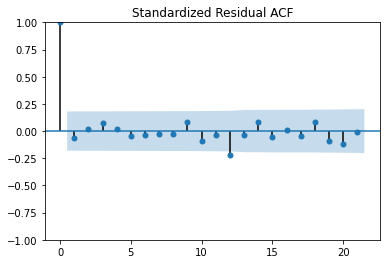

<Figure size 432x288 with 0 Axes>

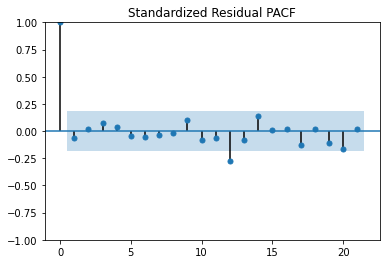

<Figure size 432x288 with 0 Axes>

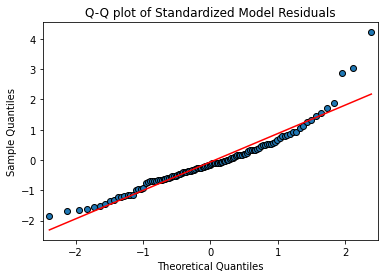

Ljung Box Test Results:
        lb_stat  lb_pvalue
21  16.923601   0.715727
McLeod-Li Test Results:
       lb_stat  lb_pvalue
21  19.35769   0.562206
Shapiro-Wilk Test Stat is 0.921511173248291 with a p-value of 3.4940208024636377e-06


In [ ]:
model = arch_model(residuals, mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit()
standRes = model_fit.resid/model_fit.conditional_volatility

# plotting standardized residuals
plt.figure()
tsaplots.plot_acf(standRes, alpha=0.05, title='Standardized Residual ACF')

# ACF of Standardized residuals
plt.figure()
tsaplots.plot_pacf(standRes, alpha=0.05, title='Standardized Residual PACF')

# Q-Q plot of standardized residuals
plt.figure()
sm.qqplot(standRes, line='s', markerfacecolor='#1f77b4', markeredgecolor='k')
plt.title('Q-Q plot of Standardized Model Residuals')
plt.show()

# RESIDUAL TESTS
# Ljung Box test
print('Ljung Box Test Results:\n ', acorr_ljungbox(standRes, lags=[21]))
# McLeod-Li test
print('McLeod-Li Test Results:\n ', acorr_ljungbox(standRes.pow(2), lags=[21]))
# Shapiro Wilk test for normality
print('Shapiro-Wilk Test Stat is {} with a p-value of {}'.format(shapiro(standRes)[0], shapiro(standRes)[1]))

In [ ]:
!pip install --upgrade --no-deps statsmodels

In [ ]:
!pip install pmdarima

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import statistics
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from scipy.stats import shapiro
import seaborn as sns

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
import pmdarima as pm

### Sentiment change over time

In [ ]:
test_packages = pd.read_csv('/content/drive/MyDrive/DataOpen/test_packages_with_sentiment.csv')

In [ ]:
test_packages["test_week"] = pd.to_datetime(test_packages["test_week"])
test_packages["created_at"] = pd.to_datetime(test_packages["created_at"])

In [ ]:
test_packages.head(1)

We want to find out what sentiment was the strongest in each of the packages, thus we define 3 new columns: max_neg, max_neu and max_pos that are boolean and indicate wheter the respective sentiment was the most pronounced.

In [ ]:
test_packages['max_neg'] = test_packages[['neg','neu','pos']].max(axis=1) == test_packages['neg']
test_packages['max_neu'] = test_packages[['neg','neu','pos']].max(axis=1) == test_packages['neu']
test_packages['max_pos'] = test_packages[['neg','neu','pos']].max(axis=1) == test_packages['pos']

We also want to know what the most pronounced sentiment in the most clicked package was. Here we (still) define the tests different than in the original data set, as we keep the week and image_id constant, but do not need to keep the specific test_id constant, as we have distinct headlines and can thus already reason about causality. The newly created boolean colomns neg_high, neu_high, pos_high thus indicate whether a respective package was the most clicked within their test and wheterh the most pronounced senteiment was negative, neutral or positive, respectively. 

In [ ]:
test_packages['neg_high'] = test_packages.max_neg.eq(True) & test_packages.high_ctr_test_image.eq(True)
test_packages['neu_high'] = test_packages.max_neu.eq(True) & test_packages.high_ctr_test_image.eq(True)
test_packages['pos_high'] = test_packages.max_pos.eq(True) & test_packages.high_ctr_test_image.eq(True)

Most of the time, negative sentiment dominates among the 3 sentiment levels

In [ ]:
test_packages[['neg_high','neu_high','pos_high']].sum()

neg_high    7228
neu_high    6545
pos_high    2677
dtype: int64

In [ ]:
weekly = test_packages.groupby('test_week').aggregate({'test_id':'count', 'impressions':'sum', 'clicks':'sum', 'max_neg':'sum', 'max_neu':'sum','max_pos':'sum', 'neg_high':'sum', 'neu_high':'sum', 'pos_high':'sum'})
weekly['clickrate'] = weekly['clicks']/weekly['impressions']

We want to know what was the weekly percentage of mostly negative, neutral or positive sentiment, respectivley. This way the results can be compared to the number of most clicked packages from each of these 3 sentiment categories.

In [ ]:
weekly['pneg'] = weekly.max_neg/weekly.test_id
weekly['pneu'] = weekly.max_neu/weekly.test_id
weekly['ppos'] = weekly.max_pos/weekly.test_id

In [ ]:
total_weekly_high = weekly.neg_high + weekly.neu_high + weekly.pos_high
weekly['pneg_high'] = weekly.neg_high/total_weekly_high
weekly['pneu_high'] = weekly.neu_high/total_weekly_high
weekly['ppos_high'] = weekly.pos_high/total_weekly_high

In [ ]:
weekly.head()

,test_id,impressions,clicks,max_neg,max_neu,max_pos,neg_high,neu_high,pos_high,clickrate,pneg,pneu,ppos,pneg_high,pneu_high,ppos_high
test_week,,,,,,,,,,,,,,,,
2013-01-21,22,42335,1165,17,3,2,6,0,1,0.027519,0.772727,0.136364,0.090909,0.857143,0.000000,0.142857
2013-01-28,19,46655,1150,5,9,5,2,2,1,0.024649,0.263158,0.473684,0.263158,0.400000,0.400000,0.200000
2013-02-04,106,302866,7134,49,45,12,16,9,6,0.023555,0.462264,0.424528,0.113208,0.516129,0.290323,0.193548
2013-02-11,187,515211,10492,80,76,31,24,19,12,0.020364,0.427807,0.406417,0.165775,0.436364,0.345455,0.218182
2013-02-18,140,424712,6011,43,62,35,16,17,12,0.014153,0.307143,0.442857,0.250000,0.355556,0.377778,0.266667


Developement of percentage of negative, neutral and positive sentiment most clicked in tested packages per week

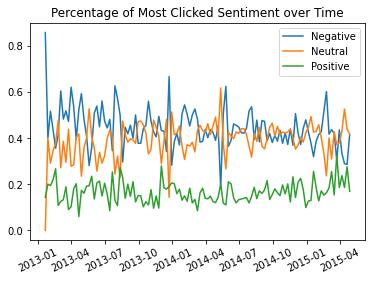

In [ ]:
plt.figure()
plt.plot(weekly.pneg_high, label='Negative')
plt.plot(weekly.pneu_high, label='Neutral')
plt.plot(weekly.ppos_high, label='Positive')
plt.title('Percentage of Most Clicked Sentiment over Time')
plt.xticks(rotation=25)
plt.legend()

In [ ]:
# Visualising the differenced series
weekly.ppos_high.plot()
tsaplots.plot_acf(weekly.ppos_high, alpha=0.05)
tsaplots.plot_pacf(weekly.ppos_high, alpha=0.05)


Sample inference for percentage of packages per week with positive sentiment. The negative and neutral sentiment time series are both constant and the best fitted ARIMA models are ARIMA(0,0,0), so a constant, for both. This in turn, indicates stable percentage of sentiment over time.  

In [ ]:
result = adfuller(weekly.pneg_high)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -10.983014
p-value: 0.000000


Clearly the three time serieses are stationary and constant with only little variation

In [ ]:
model = pm.auto_arima(weekly.ppos_high, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-379.933, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-79.108, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-309.646, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-164.236, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-378.384, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-378.322, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-214.451, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-347.745, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-375.933, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-385.307, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-384.817, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-384.839, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-385.424, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-384.878, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept 

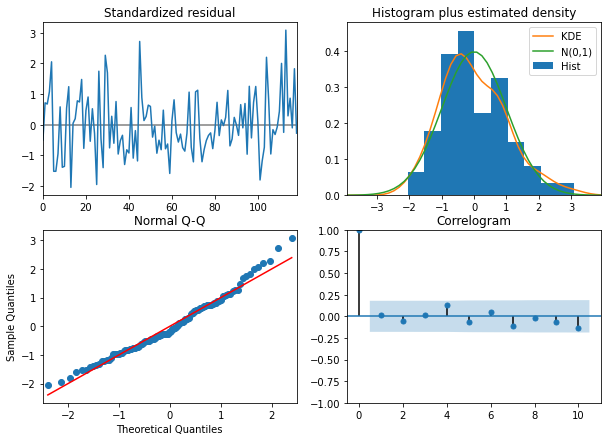

In [ ]:
model.plot_diagnostics(figsize=(10,7))
plt.show()